# House Price Prediction with Linear Regression (NumPy-Only)

Predicting house prices is a classic machine learning problem — simple on the surface, but rich in practical insight. In this project, we’ll build a linear regression model **from scratch** using only **NumPy** and **Pandas** only for data loading and exploration., without relying on high-level ML libraries like scikit-learn or TensorFlow.

We'll use the [Seattle House Price Prediction dataset](https://www.kaggle.com/datasets/samuelcortinhas/house-price-prediction-seattle) from Kaggle, which contains features like square footage, number of bedrooms, and zip code to predict the price of a house.

This project will walk through:
- Loading and preprocessing real-world data
- Implementing the cost function and gradient descent from scratch
- Applying feature scaling for stable training
- Visualizing the model's learning progress
- Making predictions and evaluating performance

> **Why build from scratch?**  
> Anyone can `.fit()` a model, but writing the algorithm manually shows true understanding — something recruiters and hiring managers value highly. It's also the best way to demystify what's happening under the hood of machine learning.

Let's get started!

## Step 1: Import Libraries

In [1]:
import math  # Mathematical functions
import warnings

import matplotlib.pyplot as plt  # Data visualizations
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulations
import seaborn as sns  # Advanced visualizations
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
    r2_score  # Model evaluation

warnings.filterwarnings('ignore')  # Supress unnecessary warnings

sns.set(style='white')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.5

## Step 2: Load and Explore the Dataset

To begin, we load the dataset containing real-world housing data from Seattle, WA. This dataset includes features such as square footage, number of bedrooms, location (zip code), and more — all of which influence the price of a house.

Let's load the data and take a first look at its structure.

### 2.1 Load Dataset

Let’s load the dataset using Pandas.

In [2]:
# Loading the dataset from the csv file 
data_train = pd.read_csv('seattle-housing-train-data.csv')
data_test = pd.read_csv('seattle-housing-test-data.csv')

# Preview first few rows
data_train.head()

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,2.5,2590.0,sqft,6000.00,sqft,98144,795000.0
1,4,2.0,2240.0,sqft,0.31,acre,98106,915000.0
2,4,3.0,2040.0,sqft,3783.00,sqft,98107,950000.0
3,4,3.0,3800.0,sqft,5175.00,sqft,98199,1950000.0
4,2,2.0,1042.0,sqft,NaN,NaN,98102,950000.0


### 2.2 Understanding the Data

Before we begin modeling, it's crucial to understand the structure and quality of the dataset. This step helps us:

- Check how many samples and features we have
- Identify any missing values or anomalies
- Data types

Exploratory steps like these ensure that we don't feed incomplete or misleading data into our model.

In [3]:
# Get a concise summary of the dataset
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            2016 non-null   int64  
 1   baths           2016 non-null   float64
 2   size            2016 non-null   float64
 3   size_units      2016 non-null   object 
 4   lot_size        1669 non-null   float64
 5   lot_size_units  1669 non-null   object 
 6   zip_code        2016 non-null   int64  
 7   price           2016 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 126.1+ KB


## Step 3: Data Cleaning

Our dataset is fairly simple, but still needs some cleaning to ensure the features are usable in a linear regression model.

Key issues identified:
- The `lot_size` column uses **mixed units** (`sqft` and `acre`), which need to be standardized
- The `size` column uses a separate `size_units` column — we should ensure all sizes are in **square feet**
- Some rows contain **missing values**
- We'll keep only the features that make sense for price prediction, and drop unit-related columns after standardization

Let’s clean the data accordingly.


### 3.1 Checking for Duplicates

Sometimes, datasets contain the exact same row more than once, maybe a property was accidentally logged twice or included in multiple records. If we don’t remove these duplicates, our model will give extra weight to those repeated rows, biasing the results.

In [4]:
def check_duplicates(data):
    """
    Checks for duplicate rows and drops them if found.
    :param data: (pd.DataFrame) The dataset
    :return: (pd.DataFrame) Cleaned dataset
    """
    duplicates = data.duplicated().sum()
    print(f'Duplicate rows: {duplicates}')

    if duplicates > 0:
        data = data.drop_duplicates()
        print("Duplicates dropped.")
    return data

In [5]:
# Check for duplicates (Train Set)
data_train = check_duplicates(data=data_train)

Duplicate rows: 9
Duplicates dropped.


In [6]:
# Check duplicates (Test Set)
data_test = check_duplicates(data=data_test)

Duplicate rows: 1
Duplicates dropped.


### 3.2 Fix Missing Values and Standardize Columns

Missing data is another common issue. In our dataset, we’ve already noticed that the `lot_size` and `lot_size_units` columns don’t have complete information for every house. If we ignore this, the model might crash or learn incorrect patterns.

There are several ways to deal with missing values:
- Dropping rows that are incomplete.
- Filling them in (imputation) using averages, medians, or even more advanced techniques.

The right choice depends on how important the column is and how much data is missing. For this case, the important column for us is the `lot_size`. We will fill the missing values with the median, but first we need to make the column values consistent since it has a mix of `sqft` and `acre`.

In [7]:
def check_missing_values(data):
    """
    Identifies and replaces empty strings with NaN, 
    then prints missing value counts.
    :param data: (pd.DataFrame) The dataset
    :return: (pd.DataFrame) Dataset with NaNs marked
    """
    categorical_cols = data.select_dtypes(include='object').columns
    data[categorical_cols] = data[categorical_cols].replace(r'^\s*$', np.nan, regex=True)

    print("Missing values per column:")
    print(data.isnull().sum())
    return data

In [8]:
# Check for missing values (Train Set)
data_train = check_missing_values(data=data_train)

Missing values per column:
beds                0
baths               0
size                0
size_units          0
lot_size          347
lot_size_units    347
zip_code            0
price               0
dtype: int64


In [9]:
# Check for missing values (Test Set)
data_test = check_missing_values(data=data_test)

Missing values per column:
beds               0
baths              0
size               0
size_units         0
lot_size          77
lot_size_units    77
zip_code           0
price              0
dtype: int64


In [10]:
def fix_missing_values(data, is_train=False, median=None):
    """
    Cleans and standardizes lot size data:
      - Converts 'lot_size' from acres to square feet where necessary
      - Fills missing values with the median (from train if is_train=True, otherwise provided)
      - Renames 'size' column to 'size_sqft'
      - Drops redundant columns: ['lot_size', 'lot_size_units', 'size_units']
    
    Parameters
    ----------
    data : pd.DataFrame
        The dataset to clean.
    is_train : bool, optional (default=False)
        If True, compute median from this dataset. If False, use provided median.
    median : float, optional
        Median value from training data. Required if is_train=False.
    
    Returns
    -------
    pd.DataFrame
        Cleaned dataset with standardized 'lot_size_sqft' and no redundant columns.
    float
        The computed median (if is_train=True), else the passed median.
    """

    # Convert lot size to sqft
    if "lot_size" in data.columns and "lot_size_units" in data.columns:
        data.insert(3, "lot_size_sqft", data.apply(
            lambda row: row['lot_size'] * 43560 if row['lot_size_units'] == 'acre' else row['lot_size'],
            axis=1
        ))
    else:
        raise ValueError("Expected columns ['lot_size', 'lot_size_units'] not found in dataset.")

    # Handle missing values
    if is_train:
        median = data['lot_size_sqft'].median()
    elif median is None:
        raise ValueError("Median must be provided when is_train=False.")

    data['lot_size_sqft'] = data['lot_size_sqft'].fillna(median)

    # Rename 'size' column if present
    if 'size' in data.columns:
        data = data.rename(columns={'size': 'size_sqft'})

    # Drop redundant columns if they exist
    drop_cols = [col for col in ['lot_size', 'lot_size_units', 'size_units'] if col in data.columns]
    data = data.drop(columns=drop_cols)

    return data, median

In [11]:
# Standardize columns and fix missing values (Train Set)
data_train, median_train = fix_missing_values(data=data_train, is_train=True)
data_train.head()

,beds,baths,size_sqft,lot_size_sqft,zip_code,price
0,3,2.5,2590.0,6000.0,98144,795000.0
1,4,2.0,2240.0,13503.6,98106,915000.0
2,4,3.0,2040.0,3783.0,98107,950000.0
3,4,3.0,3800.0,5175.0,98199,1950000.0
4,2,2.0,1042.0,5000.0,98102,950000.0


In [12]:
# Standardize columns and fix missing values (Test Set)
data_test, _ = fix_missing_values(data=data_test, is_train=False, median=median_train)
data_test.head()

,beds,baths,size_sqft,lot_size_sqft,zip_code,price
0,3,3.0,2850.0,4200.0,98119,1175000.0
1,4,5.0,3040.0,5002.0,98106,1057500.0
2,3,1.0,1290.0,6048.0,98125,799000.0
3,3,2.0,2360.0,12196.8,98188,565000.0
4,3,3.5,1942.0,1603.0,98107,1187000.0


## Step 4: Exploratory Data Analysis (EDA)

Once our data is cleaned, the next step is to explore it. EDA is like detective work: we’re trying to uncover patterns, relationships, and potential problems in the data before we build any models.

The goal here isn’t just to generate pretty charts, it’s to understand how the features behave, how they relate to the target variable (`price`), and whether there are any issues (like outliers or skewed distributions) that could confuse our model.

We’ll look at the data in three stages: univariate (one variable at a time), bivariate (two variables), and multivariate (many variables together).


### 4.1 Univariate Analysis of Target Variable (price)

We’ll start by focusing on our target variable: `price`. Since our whole project is about predicting house prices, it makes sense to deeply understand what those prices look like in the dataset.

#### 4.1.1 Statistical Information

The `.describe()` method gives us basic summary statistics — mean, median, minimum, maximum, and quartiles. This quick snapshot helps us see whether house prices are generally high, low, or spread out across a wide range.

In [13]:
data_train['price'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
price,2007.0,964070.006976,946123.655973,159000.0,600000.0,800000.0,1109000.0,25000000.0


Looking at the summary statistics for price, a few things stand out:

- There are 504 houses in our dataset.
- The average (mean) price is about &dollar;979,500, but the median (50%) price is lower at &dollar;840,000. This gap suggests that there are some very expensive homes pulling the mean upwards.
- Most homes fall between &dollar;620,000 (25th percentile) and &dollar;1,156,000 (75th percentile).
- The cheapest home is priced at &dollar;170,000, while the most expensive reaches an eye-popping &dollar;6.25 million.
- The standard deviation is very high (~&dollar;609,000), which tells us house prices vary a lot across the dataset.
In short, Seattle’s housing market is highly varied, with most homes clustered under $1.2M, but a handful of luxury properties driving up the average.

#### 4.1.2 Check for Outliers

Outliers are unusually high or low values that don’t fit the general trend. For house prices, these might be ultra-luxury homes worth millions, which could distort the scale of our model. Spotting and handling them is important because linear regression is sensitive to extreme values.

In [14]:
q1 = data_train['price'].quantile(0.25)
q3 = data_train['price'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
outliers = data_train[(data_train['price'] < lower) | (data_train['price'] > upper)]['price']
print(f'Outliers: {len(outliers)}')

Outliers: 116


Outliers in the `price` column, are found to be **116 houses** that stand far outside the typical price range. These are mostly ultra-luxury properties worth millions, compared to the majority of homes priced under &dollar;1.2M.

Outliers aren’t “bad data”, they’re real houses, but they can heavily influence a linear regression model, pulling the regression line towards them. That’s why it’s important to identify them now. Later, we’ll decide whether to keep them (if they’re relevant for prediction) or remove them (if they distort the model too much).

#### 4.1.3 Check for skewness

Skewness tells us whether the distribution of prices leans heavily to the left (a few very cheap homes) or to the right (a few extremely expensive homes). Since linear regression assumes normally distributed errors, a highly skewed target variable could affect model performance.

In [15]:
# Check for skewness
print(f'Skewness: {data_train['price'].skew():,.2f}')

Skewness: 16.91


Since our skewness is **16.91**, that’s strong positive skewness. This means most Seattle homes are clustered in the lower-to-mid price ranges, but a handful of very expensive luxury houses stretch the distribution to the right.

This also explains why the mean price (&dollar;964K) is higher than the median price (&dollar;800K) — those multi-million-dollar homes are pulling the average upward.

#### 4.1.4 Distribution of the price variable

Finally, we’ll visualize house prices using a histogram (or histplot in Seaborn). This gives us a clear picture of how prices are spread out, whether most homes fall into a certain price range or whether the distribution is uneven.

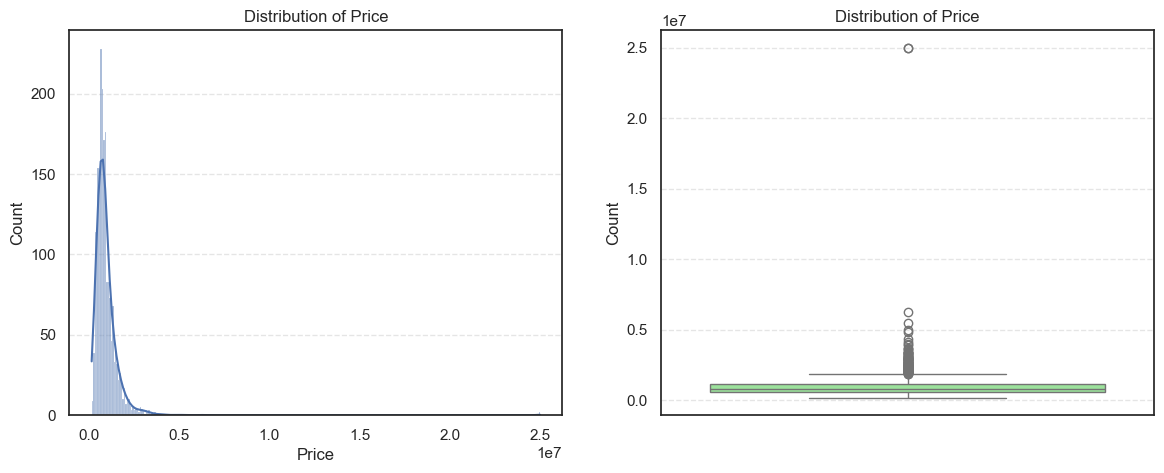

In [16]:
plt.figure(figsize=(14, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train['price'], kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Count')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data_train['price'], color='lightgreen')
plt.title('Distribution of Price')
plt.ylabel('Count')

plt.show()

The histogram shows a right-skewed distribution, with most houses priced between &dollar;600k and &dollar;1.1M, while the boxplot further highlights this skew with many high-value outliers extending far above the upper whisker. Together, these visualizations confirm that Seattle’s housing prices are dominated by moderately priced homes, but with a significant presence of ultra-expensive properties driving up the mean.

### 4.2 Bivariate Analysis of Numerical Values vs. Target (price)

Once we understand the target, the next step is to explore how other numerical variables (like beds, baths, size, lot_size) relate to price.

#### 4.2.1 Correlation Heatmap

A correlation heatmap gives us a bird’s-eye view of relationships between variables. For instance, we might find that:
- size has a strong positive correlation with price (bigger homes → more expensive).
- beds and size are also strongly correlated (bigger houses usually mean more bedrooms).

This helps us identify which variables are likely to be the strongest predictors, and also warns us about multicollinearity (when two features are so closely related that they could confuse the model).

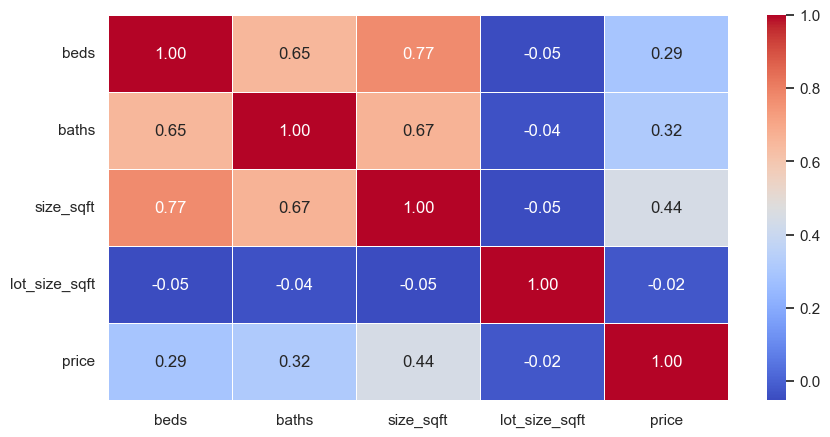

In [17]:
# Drop zip_code from the numerical columns as that is a categorical variable not continuous.
numerical_cols = data_train.select_dtypes(include='number').columns.drop(['zip_code'])

# Plot correlation heatmap
corr_mat = data_train[numerical_cols].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.yticks(rotation=0)
plt.show()

Key insights include:

- `size_sqft` had the strongest linear relationship with price.
- `beds` and `baths` were step-wise (less ideal for simple linear regression).
- `lot_size_sqft` was noisy, bigger lots didn’t always mean higher prices.

#### 4.2.2 Scatter plot
Scatter plots are one of the most powerful ways to see relationships between a single feature and the target. For example:

- `size` vs. `price`: Do bigger houses generally cost more?
- `beds` vs. `price`: Does adding bedrooms always increase price, or is there a limit?

By plotting these, we can spot patterns (linear or non-linear) and also detect if some variables don’t really influence price much at all.

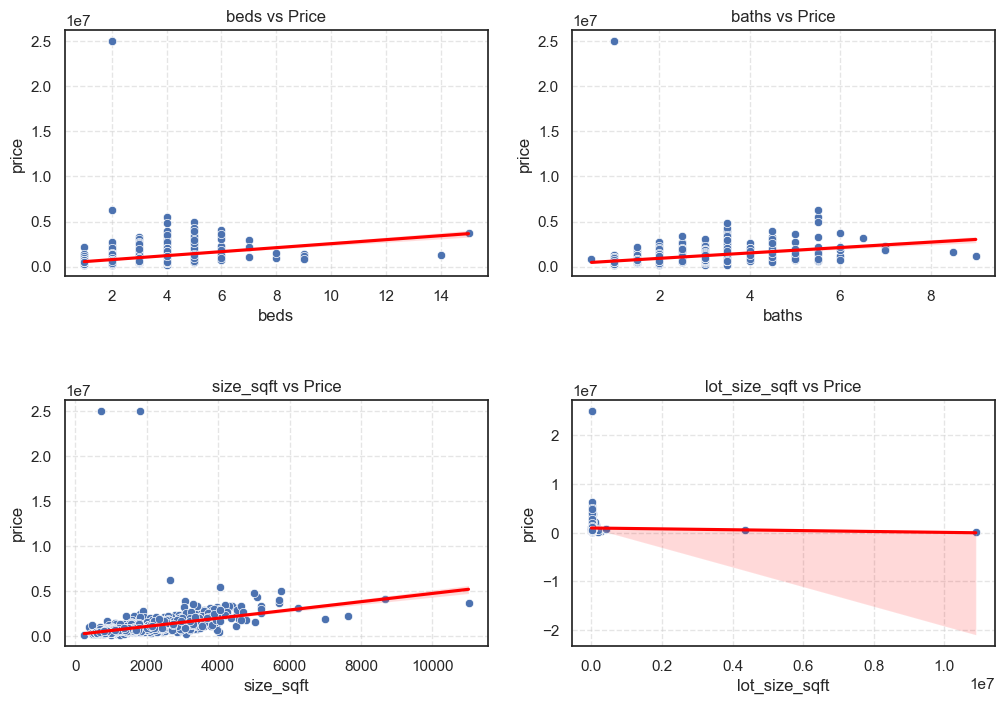

In [18]:
# Drop price so that we can compare against it.
numerical_cols = numerical_cols.drop(['price'])

n_cols = 2
n_rows = math.ceil(len(numerical_cols) / n_cols)
plt.figure(figsize=(6 * n_cols, 4 * n_rows))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(data=data_train, x=col, y='price')
    plt.title(f'{col} vs Price')
    sns.regplot(
        x=col,
        y="price",
        data=data_train,
        scatter=False,
        color="red",
    )
    plt.grid(True)

plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.show()

**Decision:** We will drop `size_sqft` to train our model for this example.

## Step 2: Implementing Linear Regression from Scratch

### 2.1 Feature Scaling (Standardization)

Before training our linear regression model, it's important to scale our input features. This is especially critical when using **gradient descent**, as it ensures faster and more stable convergence.

We'll use **Z-score standardization**, which transforms our feature `X` into a distribution with:
- Mean = 0
- Standard deviation = 1

The formula is:

$$
X_{\text{scaled}} = \frac{X - \mu}{\sigma}
$$


Where:
- $\mu$ is the mean of the feature
- $\sigma$ is the standard deviation of the feature

This ensures the feature values are on the same scale, making gradient descent more effective.

In [19]:
def preprocess_features_targets(X_train, y_train, X_test, y_test):
    """
    Standardizes features and log-transforms the target for both train and test sets.
    
    Parameters
    ----------
    X_train : np.ndarray
        Training feature array (1D or 2D).
    y_train : np.ndarray
        Training target array (1D).
    X_test : np.ndarray
        Test feature array (1D or 2D).
    y_test : np.ndarray
        Test target array (1D).
    
    Returns
    -------
    X_train_scaled : np.ndarray
        Scaled training features.
    y_train_log : np.ndarray
        Log-transformed training target.
    X_test_scaled : np.ndarray
        Scaled test features (using train mean & std).
    y_test_log : np.ndarray
        Log-transformed test target.
    x_mean : float
        Mean of training features (for inverse transform).
    x_std : float
        Standard deviation of training features (for inverse transform).
    """

    # Compute scaling parameters from training set only
    x_mean = X_train.mean()
    x_std = X_train.std()

    # Scale features
    X_train_scaled = (X_train - x_mean) / x_std
    X_test_scaled = (X_test - x_mean) / x_std

    # Log transform target
    y_train_log = np.log(y_train)
    y_test_log = np.log(y_test)

    return X_train_scaled, y_train_log, X_test_scaled, y_test_log, x_mean, x_std

In [29]:
# Extract the feature and target
X_train = data_train['size_sqft']
y_train = data_train['price']

X_test = data_test['size_sqft']
y_test = data_test['price']

X_train_scaled, y_train_log, X_test_scaled, y_test_log, x_mean, x_std = preprocess_features_targets(
    X_train, y_train, X_test, y_test
)

# Preview results
print(f"Mean: {x_mean:.2f}")
print(f"Standard Deviation: {x_std:.2f}")
print(f"First 5 scaled values of the train set:")
print(X_train_scaled[:5])

Mean: 1738.77
Standard Deviation: 920.33
First 5 scaled values of the train set:
0    0.924913
1    0.544616
2    0.327304
3    2.239652
4   -0.757084
Name: size_sqft, dtype: float64


### 2.2 Cost Function – Mean Squared Error (MSE)

To train our linear regression model, we need a way to measure **how well our model's predictions match the actual values**. This is the role of the **cost function**.

The most commonly used cost function for regression is the **Mean Squared Error (MSE)**:

$$
J(w, b) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2
$$

Where:
- $ m $ is the number of training examples
- $ \hat{y}^{(i)} = w \cdot x^{(i)} + b $ is the predicted value for the i-th example
- $ y^{(i)} $ is the actual target value
- $ w $ is the weight (slope), and $ b $ is the bias (intercept)

>  We include the factor $ \frac{1}{2} $ to simplify the derivative during gradient descent.

This function calculates the **average squared difference** between predicted and actual values — lower is better.


In [21]:
def predict(x, w, b):
    """
    Predict using learned linear regression parameters.
    
    Parameters:
    x (array): Input features
    w (float): Trained weight
    b (float): Trained bias

    Returns:
    array: Predicted values
    """
    return np.dot(x, w) + b

In [22]:
# Define the cost function
def compute_cost(x_train, y_train, w, b):
    """
    Compute the Mean Squared Error cost function.
    
    Parameters:
    x_train (array): Input features (scaled)
    y_train (array): Actual target values
    w (float): Weight (slope)
    b (float): Bias (intercept)

    Returns:
    float: Cost J(w, b)
    """

    m = len(y_train)
    y_hat = predict(x_train, w, b)
    cost = (1 / (2 * m)) * np.sum((y_hat - y_train) ** 2)
    return cost

### 2.3 Gradient Descent

Now that we can measure the model's error using the cost function (MSE), we need a way to **minimize** that error. This is where **Gradient Descent** comes in.

Gradient Descent is an optimization algorithm that iteratively adjusts the model parameters (weight `w` and bias `b`) to **move in the direction that reduces the cost**.

<br>

#### Update Rules:

$$
w := w - \alpha \cdot \frac{\partial J}{\partial w}
$$
$$
b := b - \alpha \cdot \frac{\partial J}{\partial b}
$$

Where:
- $ \alpha $ is the learning rate, (how big each step is)
- $ \frac{\partial J}{\partial w} $, $ \frac{\partial J}{\partial b} $ are the **gradients** of the cost function with respect to `w` and `b`

#### Intuition:
- The gradients tell us **how steep the slope is** (how fast cost is increasing)
- We move in the **opposite direction of the slope** to minimize cost


In [23]:
# Define the gradient descent function
def gradient_descent(x_train, y_train, w, b, learning_rate, iterations):
    """
    Performs batch gradient descent to learn w and b.

    Parameters:
    x_train (array): Input features (scaled)
    y_train (array): Target values
    w (float): Initial weight
    b (float): Initial bias
    learning_rate (float): Step size for each update
    iterations (int): Number of training iterations

    Returns:
    w, b (float): Learned parameters
    cost_history (list): Cost at each iteration
    """
    m = len(y_train)
    cost_history = []

    for i in range(iterations):
        y_hat = predict(x_train, w, b)
        error = y_hat - y_train

        # Compute gradients
        dw = (1 / m) * np.dot(error, x_train)
        db = (1 / m) * np.sum(error)

        # Update parameters
        w -= learning_rate * dw
        b -= learning_rate * db

        # Track cost
        cost = compute_cost(x_train, y_train, w, b)

        if i % 100 == 0 or i == iterations - 1:
            print(f"Iteration {i}: Cost = {cost:.2f}, w = {w:.4f}, b = {b:.4f}")

        if i != 0 and abs(cost - cost_history[-1]) < 1e-06:
            print(f"Converged at iteration {i}")
            break

        cost_history.append(cost)
    return w, b, cost_history

### 2.4 Train the Model Using Gradient Descent
We now need to train the model using the gradient descent but first we need to set the hyperparameters

In [24]:
# Set hyperparameters
iterations = 10000
learning_rate = 0.001
initial_weight = 0
initial_bias = 0

# Train the model
final_weight, final_bias, cost_history = gradient_descent(
    X_train_scaled, y_train_log, initial_weight, initial_bias, learning_rate, iterations
)
print(f"Final Parameters: w = {final_weight:.4f}, b = {final_bias:.4f}")

Iteration 0: Cost = 92.73, w = 0.0004, b = 0.0136
Iteration 100: Cost = 75.92, w = 0.0371, b = 1.3093
Iteration 200: Cost = 62.17, w = 0.0702, b = 2.4816
Iteration 300: Cost = 50.90, w = 0.1003, b = 3.5423
Iteration 400: Cost = 41.68, w = 0.1274, b = 4.5020
Iteration 500: Cost = 34.13, w = 0.1520, b = 5.3703
Iteration 600: Cost = 27.95, w = 0.1743, b = 6.1559
Iteration 700: Cost = 22.90, w = 0.1944, b = 6.8668
Iteration 800: Cost = 18.75, w = 0.2126, b = 7.5100
Iteration 900: Cost = 15.36, w = 0.2291, b = 8.0919
Iteration 1000: Cost = 12.59, w = 0.2440, b = 8.6185
Iteration 1100: Cost = 10.32, w = 0.2575, b = 9.0949
Iteration 1200: Cost = 8.46, w = 0.2697, b = 9.5259
Iteration 1300: Cost = 6.93, w = 0.2807, b = 9.9159
Iteration 1400: Cost = 5.69, w = 0.2907, b = 10.2688
Iteration 1500: Cost = 4.67, w = 0.2998, b = 10.5881
Iteration 1600: Cost = 3.83, w = 0.3079, b = 10.8770
Iteration 1700: Cost = 3.15, w = 0.3153, b = 11.1383
Iteration 1800: Cost = 2.59, w = 0.3220, b = 11.3748
Iterati

### 2.5 Predictions and Regression Line

With the model trained, we can now generate predictions for house prices using the learned parameters.

Since our model was trained on **standardized data**, we will:
1. Use the learned `w` and `b` to make predictions on `X_scaled`
2. Convert the predictions back to the **original price scale** using the inverse Z-score formula:
   $$
   \hat{y}_{\text{original}} = \hat{y}_{\text{scaled}} \times \sigma_y + \mu_y
   $$
3. Plot the regression line over the original data to visualize how well the model fits.

This will give us a clear view of how accurately our NumPy-based linear regression model captures the relationship between house size and price.


In [25]:
# Predict scaled prices (log-space)
y_hat_log = final_weight * X_test_scaled + final_bias
y_hat = np.exp(y_hat_log)  # Convert back to original price scale

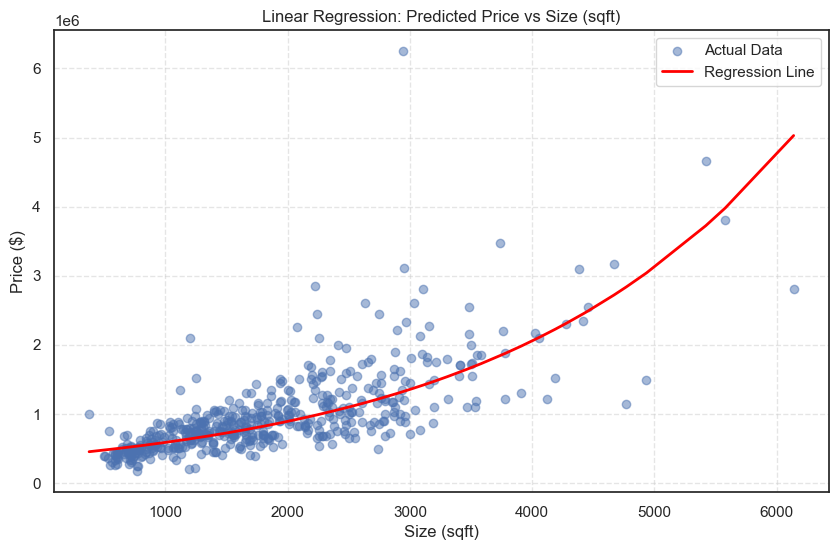

In [31]:
# Convert to NumPy for plotting
X_test_np = np.array(X_test)          # original sqft
y_test_np = np.array(y_test)          # original prices
y_hat_np = np.array(y_hat)            # predicted prices

# Sort values by X for a clean regression line
sorted_idx = np.argsort(X_test_np)
X_sorted = X_test_np[sorted_idx]
y_hat_sorted = y_hat_np[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test_np, y_test_np, label="Actual Data", alpha=0.5)
plt.plot(X_sorted, y_hat_sorted, color="red", label="Regression Line", linewidth=2)
plt.title("Linear Regression: Predicted Price vs Size (sqft)")
plt.xlabel("Size (sqft)")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

### 2.6 Model Evaluation: RMSE and R² Score

After training and visualizing the model's fit, we now want to **quantify its performance**.

We'll use two standard regression metrics

<br>

#### 1. **RMSE (Root Mean Squared Error)**  
Measures the average prediction error in the same units as the target variable (price in dollars):

$$
\text{RMSE} = \sqrt{ \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2 }
$$

Lower RMSE = better fit.

<br>

#### 2. **R² Score (Coefficient of Determination)**  
Represents the proportion of variance in the target explained by the model:

$$
R^2 = 1 - \frac{ \sum (\hat{y} - y)^2 }{ \sum (y - \bar{y})^2 }
$$

- $ R^2 = 1.0 $: perfect prediction  
- $ R^2 = 0.0 $: model predicts the mean  
- $ R^2 < 0 $: worse than guessing the mean

Let’s compute both to evaluate how well our NumPy-based linear regression model performs.


In [26]:
# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_hat))

# Compute R² score
r2 = r2_score(y_test, y_hat)

# Display results
print(f"RMSE: ${rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: $441,233.39
R² Score: 0.4742


## Final Summary & Reflections

In this project, we built a **linear regression model from scratch using NumPy** to predict house prices in Seattle. We worked step by step through the full machine learning pipeline, including:

- **Data cleaning & preprocessing** (unit standardization, missing value handling)
- **Exploratory data analysis** (scatter plots, correlation checks)
- **Feature scaling** using Z-score normalization
- **Model implementation**: cost function (MSE), gradient descent
- **Model training and prediction** with visualization
- **Model evaluation** using RMSE and R² Score

<br>

### Key Learnings

- Implementing algorithms from scratch is the best way to deeply understand how they work
- Feature selection significantly impacts model performance
- Standardizing data is crucial when using gradient descent
- Real-world data is messy — handling units, missing values, and scale differences is essential
- Evaluation metrics tell the **real story** about a model’s performance